In [12]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter, LinearLocator

import ee
import geemap

from functools import partial

In [10]:
sentinel_max_time

Timestamp('2022-06-05 04:40:35.310000')

(24, 200)


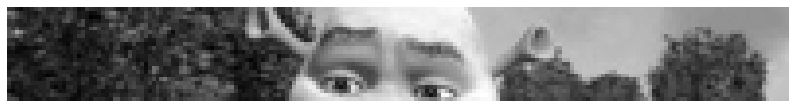

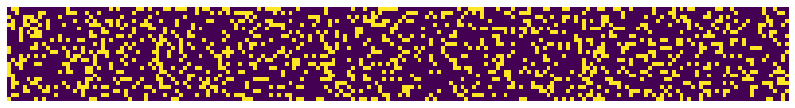

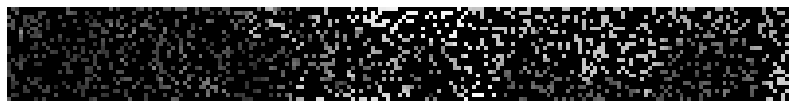

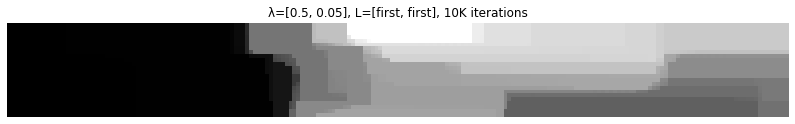

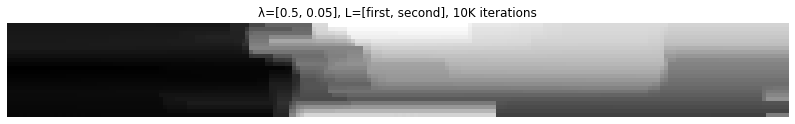

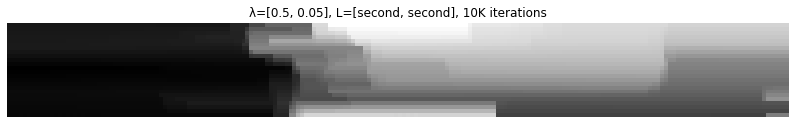

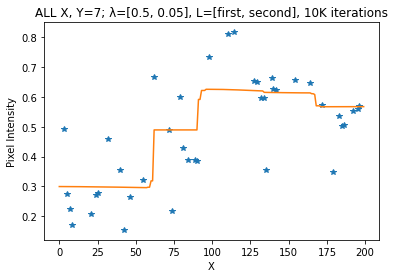

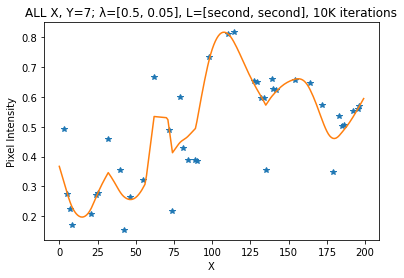

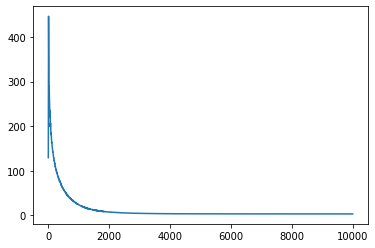

In [14]:
from os import chdir
chdir("../Piecewise Constant Denoising/");
%run "../Piecewise Constant Denoising/Khalid_Chambolle_Pock_LinearAndConstant.ipynb"
chdir("../EarthEngine");

In [15]:
df = pd.read_csv(f"Lhasa/Lhasa_Data-CC-80.csv", index_col=0);
df["SENSING_TIME"] = df["SENSING_TIME"].map(pd.Timestamp);
df['BRAIDING_INDEX'] = (df['TOTAL_PERIM_SMOOTH']/2)/2000;

dfs = pd.read_csv(f"Lhasa/Lhasa_Sentinel_Data-CC-80.csv", index_col=0);
dfs["SENSING_TIME"] = dfs["SENSING_TIME"].map(partial(pd.to_datetime, unit='ms'));
dfs['BRAIDING_INDEX'] = (dfs['TOTAL_PERIM_SMOOTH']/2)/2000; # BARBARA: Is this correct?

# Restrict range
sentinel_min_time = dfs["SENSING_TIME"].min();
sentinel_max_time = dfs["SENSING_TIME"].max();
df_crop = df[(df["SENSING_TIME"] >= sentinel_min_time) & (df["SENSING_TIME"] <= sentinel_max_time)];

In [16]:
def get_plot(df, d, index_name="BRAIDING_INDEX", st_range=None):
    # df = df.groupby(["x", "t"]).mean().reset_index()
    df = df.groupby(["ID", "SENSING_TIME"]).max().reset_index();
    
    df["x"] = df["ID"] - df["ID"].min();
    
    if(st_range == None):
        df["t"] = (df["SENSING_TIME"] - df["SENSING_TIME"].min()).map(lambda t: t.days // d).astype(int);
        Z = np.full((df["x"].max()+1, df["t"].max()+1), np.nan);
    else:
        df_t_range = ((st_range[1]-st_range[0]).days // d);
        df["t"] = (df["SENSING_TIME"] - st_range[0]).map(lambda t: t.days // d).astype(int);
        Z = np.full((df["x"].max()+1, df_t_range+1), np.nan);
        
    M = np.full((df["x"].max()+1, df["t"].max()+1), 0);
    # print(Z.shape)
    for k, v in df[["x", "t", index_name]].iterrows():
        x = v["x"].astype(int);
        t = v["t"].astype(int);
        if(M[x, t] == 0):
            Z[x, t] = v[index_name];
        else:
            Z[x, t] = (Z[x, t]*M[x, t] + v[index_name])/(M[x, t] + 1);
    #           Z[x, t] = max(Z[x, t], v["BRAIDING_INDEX"]) # TAKE MAX INSTEAD OF MEAN
        M[x, t] += 1;
    return (Z, M);

# Modify order for Ver/Hor
def interpolate(Z):
    xt_data = Z.copy();
    mask = np.ones(xt_data.shape);
    mask[np.isnan(xt_data)] = 0;
    xt_data[np.isnan(xt_data)] = 0;

    sigma = 0.05
    tau = 0.99/(1 + 4*sigma);
    xt_cp, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask,
        lamb=LAMBDA_VALUE,
        tau=tau,sigma=sigma,Niter=5000)
    return xt_cp;

def calculate_sparsity(Z):
    return (np.count_nonzero(~np.isnan(Z)))/(Z.shape[0]*Z.shape[1]);

class CustomFormatter(Formatter):
    def __init__(self, min_time, days, fmt='%Y-%m-%d'):
        self.min_time = min_time;
        self.days = days;
        self.fmt = fmt;
    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x));
        return (self.min_time + pd.DateOffset(days=self.days*ind)).strftime(self.fmt);


Landsat:   0.4249775381850854
Sentinel:  0.7048925916850445
Merged:    0.7967818345176836
2018-12-16 04:50:13.963000
Range:	 9 0 12-16-2018 -> 9 3 01-09-2019
Range:	 9 11 03-14-2019 -> 9 12 03-22-2019
Range:	 9 15 04-15-2019 -> 9 16 04-23-2019
Range:	 9 25 07-04-2019 -> 9 26 07-12-2019
Range:	 9 27 07-20-2019 -> 9 30 08-13-2019
Range:	 9 31 08-21-2019 -> 9 33 09-06-2019
Range:	 9 35 09-22-2019 -> 9 36 09-30-2019
Range:	 9 54 02-21-2020 -> 9 55 02-29-2020
Range:	 9 65 05-19-2020 -> 9 68 06-12-2020
Range:	 9 69 06-20-2020 -> 9 74 07-30-2020
Range:	 9 75 08-07-2020 -> 9 78 08-31-2020
Range:	 9 79 09-08-2020 -> 9 80 09-16-2020
Range:	 9 101 03-03-2021 -> 9 102 03-11-2021
Range:	 9 109 05-06-2021 -> 9 110 05-14-2021
Range:	 9 111 05-22-2021 -> 9 112 05-30-2021
Range:	 9 117 07-09-2021 -> 9 119 07-25-2021
Range:	 9 121 08-10-2021 -> 9 124 09-03-2021
Range:	 9 129 10-13-2021 -> 9 130 10-21-2021
Range:	 9 142 01-25-2022 -> 9 144 02-10-2022
Range:	 9 145 02-18-2022 -> 9 146 02-26-2022
Range:	 9

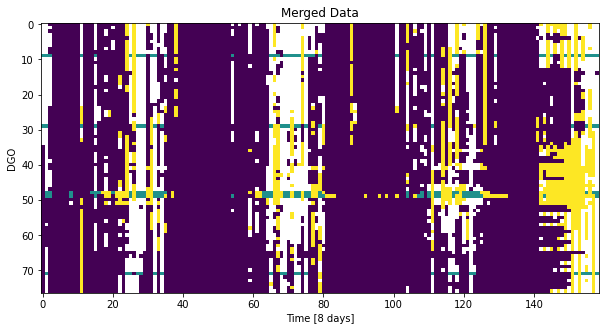

In [17]:
d = 8;
Z_L, M_L = get_plot(df_crop, d=d, st_range=[sentinel_min_time, sentinel_max_time]);
Z_S, M_S = get_plot(dfs, d=d);

# Merge Data!
# TODO: Look into combining identical cells rather than missing cells
F_merge = np.full(Z_S.shape, np.nan);
Z_merge = Z_S.copy();
for i in range(Z_merge.shape[0]):
    for j in range(Z_merge.shape[1]):
        if(np.isnan(Z_merge[i,j])):
            Z_merge[i, j] = Z_L[i, j];
        if(not np.isnan(Z_S[i, j])):
            F_merge[i, j] = 0;
        elif(not np.isnan(Z_L[i, j])):
            F_merge[i, j] = 1;

print("Landsat:  ", calculate_sparsity(Z_L));
print("Sentinel: ", calculate_sparsity(Z_S));
print("Merged:   ", calculate_sparsity(Z_merge));
print(sentinel_min_time);

last_t = None;
for dgo_p1 in [10, 30, 49, 50, 72]:
    dgo = dgo_p1-1;
    for t in range(F_merge.shape[1]):
        if(np.isnan(F_merge[dgo, t])):
            if(last_t != t-1):
                # New range
                start_time = sentinel_min_time + pd.DateOffset(days=d*t);
                print("Range:\t", dgo, t, start_time.strftime("%m-%d-%Y"), end=" -> ");
            F_merge[dgo, t] = 0.5;
            last_t = t;
        else:
            if(t == last_t+1):
                end_time = sentinel_min_time + pd.DateOffset(days=d*t);
                print(dgo, t, end_time.strftime("%m-%d-%Y"));
plt.figure(figsize=(10, 6));
plt.imshow(F_merge);
plt.title("Merged Data");
plt.xlabel(f'Time [{d} days]');
plt.ylabel('DGO');


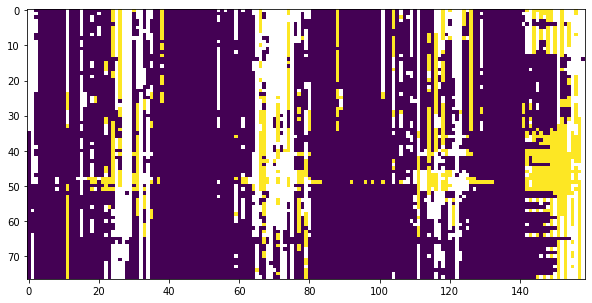

In [202]:


# # fig, axs = plt.subplots(2, 1, constrained_layout=True);
# # axs[0].imshow(Z_L);
# # axs[1].imshow(Z_S);
# plt.figure(figsize=(10, 6));
# plt.imshow(Z_L);
# plt.figure(figsize=(10, 6));
# plt.imshow(Z_S);
# plt.figure(figsize=(10, 6));
# plt.imshow(Z_merge);


In [19]:
import scipy
import scipy.io

{'LAMBDA': [5, 5], 'mode': ('second', 'second')}
{'LAMBDA': [3, 1], 'mode': ('second', 'first')}
{'LAMBDA': [3, 1], 'mode': ('second', 'second')}


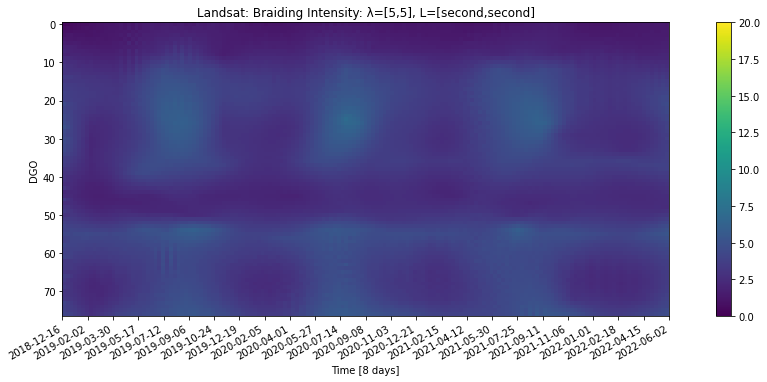

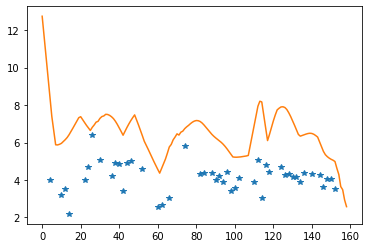

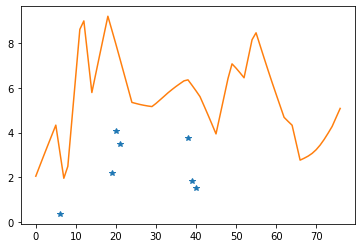

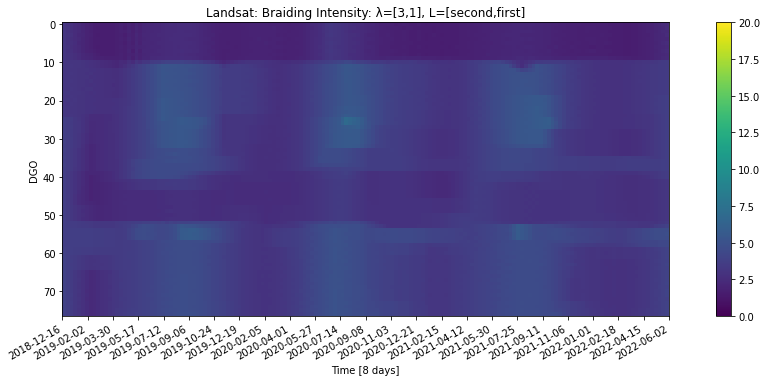

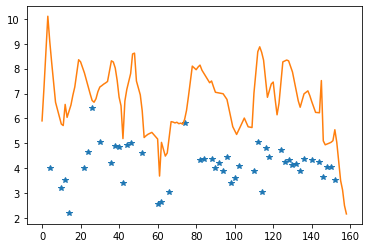

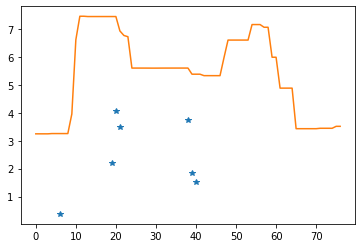

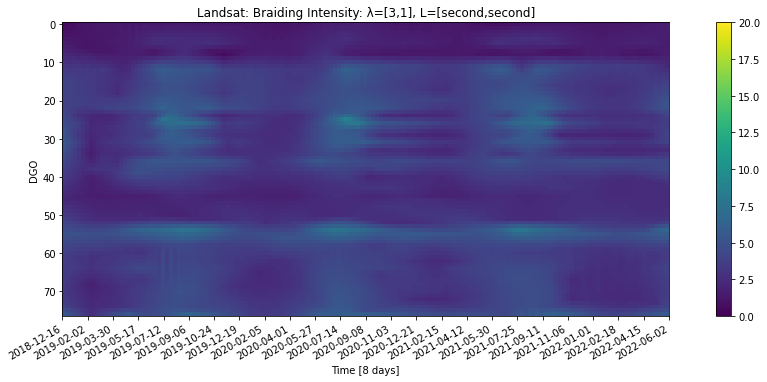

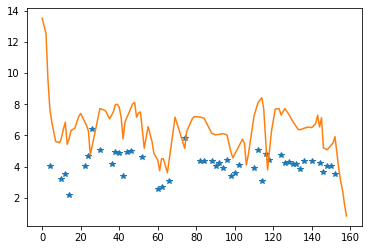

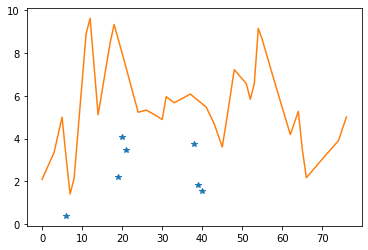

In [20]:
# print(landsat_matrix.shape, sentinel_matrix.shape);

# Ratio 
parameters = [
    {"LAMBDA": [5, 5], "mode": ('second', 'second')},
    # {"LAMBDA": [3, 3], "mode": ('second', 'second')},
    {"LAMBDA": [3, 1], "mode": ('second', 'first')},
    {"LAMBDA": [3, 1], "mode": ('second', 'second')},
    # {"LAMBDA": [2, 2], "mode": ('second', 'second')},
    # {"LAMBDA": [1, 1], "mode": ('first', 'first')},
    # {"LAMBDA": [1, 1], "mode": ('second', 'second')},
    # {"LAMBDA": [0.5, 0.5], "mode": ('second', 'second')},
    # {"LAMBDA": [0.75, 0.75], "mode": ('second', 'second')},
    # {"LAMBDA": [5, 0.75], "mode": ('second', 'first')}
    # {"LAMBDA": [0.5, 0.5], "mode": ('second', 'second')},
    # {"LAMBDA": [0.5, 0.5], "mode": ('second', 'first')},
    # {"LAMBDA": [0.1, 0.1], "mode": ('second', 'second')},
    # {"LAMBDA": [0.01, 0.01], "mode": ('second', 'second')},
    # {"LAMBDA": [0.005, 0.005], "mode": ('second', 'second')}
];
output_data = {};
def do(p):
    global LAMBDA_VALUE;
    global DivVer, DivHor;
    global GradientVer, GradientHor;
    LAMBDA_VALUE = np.array(p["LAMBDA"]);
    DivVer = lambda x: DivOrder(x, axis=0, order=p["mode"][0]);
    DivHor = lambda x: DivOrder(x, axis=1, order=p["mode"][1]);   
    GradientVer = lambda x: GradientOrder(x, axis=0, order=p["mode"][0]);
    GradientHor = lambda x: GradientOrder(x, axis=1, order=p["mode"][1]);   

    landsat_matrix = interpolate(Z_L);
    sentinel_matrix = interpolate(Z_S);
    # merged_matrix = interpolate(Z_merge);

    l1, l2, m1, m2 = p["LAMBDA"][0], p["LAMBDA"][1], p["mode"][0], p["mode"][1];
    l1 = str(l1).replace(".", "p");
    l2 = str(l2).replace(".", "p");
    
    # plt.figure(figsize=(17, 6));
    # plt.imshow(Z_L, vmin=0, vmax=20);
    # plt.colorbar();
    # plt.xlabel(f'Time [{d} days]');
    # plt.ylabel('DGO');
    # plt.title(f'{l1}_{l2}_{m1}_{m2}_landsat');
    # plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_landsat");
    # output_data[f'{l1}_{l2}_{m1}_{m2}_landsat'] = Z_L;
    
    
    plt.figure(figsize=(17, 6));
    plt.imshow(landsat_matrix, vmin=0, vmax=20);
    plt.colorbar();
    plt.xlabel(f'Time [{d} days]');
    plt.ylabel('DGO');
    plt.title(f"Landsat: Braiding Intensity: λ=[{l1},{l2}], L=[{m1},{m2}]");
    plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_landsat_cp");
    plt.gca().xaxis.set_major_locator(LinearLocator(numticks=25))
    plt.gca().xaxis.set_major_formatter(CustomFormatter(sentinel_min_time, d))
    plt.gcf().autofmt_xdate()
    # output_data[f'{l1}_{l2}_{m1}_{m2}_landsat_cp'] = landsat_matrix;
    scipy.io.savemat(f'../mat/{l1}_{l2}_{m1}_{m2}_landsat.mat', dict(x=Z_L));
    scipy.io.savemat(f'../mat/{l1}_{l2}_{m1}_{m2}_landsat_cp.mat', dict(x=landsat_matrix));
    
    # plt.figure(figsize=(17, 6));
    # plt.imshow(Z_S, vmin=0, vmax=20);
    # plt.colorbar();
    # plt.xlabel(f'Time [{d} days]');
    # plt.ylabel('DGO');
    # plt.title(f"{l1}_{l2}_{m1}_{m2}_sentinel");
    # plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_sentinel");
    # output_data[f'{l1}_{l2}_{m1}_{m2}_sentinel'] = Z_S;
    
    # plt.figure(figsize=(17, 6));
    # plt.imshow(sentinel_matrix, vmin=0, vmax=20);
    # plt.colorbar();
    # plt.xlabel(f'Time [{d} days]');
    # plt.ylabel('DGO');
    # plt.title(f"Sentinel-2: Braiding Intensity: λ=[{l1},{l2}], L=[{m1},{m2}]");
    # plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_sentinel_cp");
    # plt.gca().xaxis.set_major_locator(LinearLocator(numticks=10))
    # plt.gca().xaxis.set_major_formatter(CustomFormatter(sentinel_min_time, d))
    # plt.gcf().autofmt_xdate()
    # output_data[] = sentinel_matrix;
    
    # scipy.io.savemat(f'save_location/{l1}_{l2}_{m1}_{m2}_sentinel.mat', dict(x=Z_S));
    # scipy.io.savemat(f'save_location/{l1}_{l2}_{m1}_{m2}_sentinel_cp.mat', dict(x=sentinel_matrix));
    
#     plt.figure(figsize=(17, 6));
#     plt.imshow(Z_merge, vmin=0, vmax=20);
#     plt.colorbar();
#     plt.xlabel(f'Time [{d} days]');
#     plt.ylabel('DGO');
#     plt.title(f"{l1}_{l2}_{m1}_{m2}_merged");
#     plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_merged_cp");

    
    # plt.figure(figsize=(17, 6));
    # plt.imshow(merged_matrix, vmin=0, vmax=20);
    # plt.colorbar();
    # plt.xlabel(f'Time [{d} days]');
    # plt.ylabel('DGO');
    # plt.title(f"{l1}_{l2}_{m1}_{m2}_merged_cp");
    # plt.savefig(f"output/{l1}_{l2}_{m1}_{m2}_merged_cp");
    
    
    plt.figure();
    plt.plot(Z_L[15, :], "*");
    plt.plot(sentinel_matrix[15, :]);

    plt.figure();
    plt.plot(Z_L[:, 6], "*");
    plt.plot(sentinel_matrix[:, 6]);
    
for k, v in enumerate(parameters):
    print(v);
    do(v);
    
# import scipy
# import scipy.io
# print(output_data);
# scipy.io.savemat('save_location/braiding.mat', output_data);
